# <span style='color:Blue'> CHECK YOUR BIAS:   </span>
## <span style='color:Blue'> A PYTHON TOOLKIT FOR FAIR LENDING  </span>

#### Summary: This toolkit explores small subset of ideas and techniques of auditing gender bias in credit assessment processes. For a comprehensive discussion of gender bias and fairness in credit assessment, see Women’s World Banking’s “Algorithmic Bias, Financial Inclusion, and Gender,” or our most recent publication, “Check Your Bias! A Field Guide for Lenders,” both available on the Women’s World Banking website. Questions or comments on this toolkit? Email Women’s World Banking at info@womensworldbanking.org.

######  Learning objectives:
###### • Increase awareness about different types of gender bias that may manifest in credit assessment processes
###### • Explore and detect gender biases and their sources in credit assessment processes

## <span style='color:Green'> Part III  - Rejected applicants</span>
### <span style='color:Green'> Using inferential statistics to audit for gender bias in credit processes 

Matching methods are a non-parametric approach that involve taking observational data, and matching people who have similar characteristics but different treatments, as a way of conducting 
causal inference or other estimations. The intuitiveness of the approach, in additional to a few 
other advantageous statistical properties, make it a useful method for reject inference as well.
There are many potential matching strategies to 
choose from, and each has its relative merits. For our purposes, we apply a recently developed 
method called coarsened exact matching. In our application of this technique, we start by identifying 
the approved and rejected applicants in the sample (i.e. we tag these as separate cohorts, but keep the sample intact). We then apply the coarsened exact matching algorithm, which divides the full sample into meaningful strata based on relevant variables of interest. The user must select these variables, taking into consideration the ones that are likely to be strong predictors of loan performance issues and also have data that is generally available (i.e., tends to be complete for all applicants). In practice, any categorical variables are subjected to exact matching and any continuous variables are split into bins.6 For each stratum, the coarsened exact matching process then identifies any matches between the approved and rejected cohorts. For our purposes, we use only strata that have 
matched approved and rejected applications. All non-matched observations/strata are ignored. For 
each stratum, where matches are found, we use the observed loan performance of the matched approved applications in a given stratum to impute predicted loan performance among the matched rejected applications. For example, we construct a variable, which we call “any NPL imputed” and set it to 1 for a given matched rejected application if the matched approved application in their strata had an NPL and set it to 0 if they did not. In the simplest scenario, if there is only one matched approved/disbursed application in the stratum, then its loan performance is used to impute the 
matched rejected applications’ performance. In the more common scenario where there are multiple 
approved/disbursed loans in the stratum, we use the mean loan performance. We set a loosely riskaverse threshold: If the actual probability of having an NPL is greater than or equal to 50% among the approved applications in the stratum, then we set “any NPL imputed” equal to 1 for the matched rejected applications and 0 otherwise. (Note that the threshold can be adjusted based on the risk tolerance of the lender.) Under this setup, we define: 
a. “False negatives” – rejected applicants
where “any NPL imputed” = 0
b. “True negatives” – rejected applicants where 
“any NPL imputed” = 1
We then combine the accepted and rejected applications into a single data set and do basic descriptive statistics on them. The outputs of this model would be similar to what we showed in following tables.

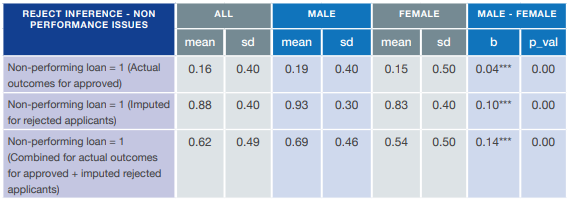

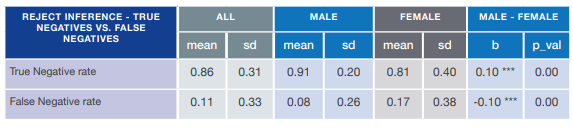


Equal treatment: any two individuals who possess the same relevant attributes should be treated the same by the algorithm. Relevantly similar individuals should be treated the same.

***

##### <span style='color:red'> Code 1:  </span>


Import packages

In [ ]:
import os 
import emoji
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt                               # used for data visualization
import seaborn as sns                                         # used for data visualization
from sklearn.linear_model import LogisticRegression           # used for data audit bias
from sklearn.preprocessing import StandardScaler              # used in distance-based matching 
from sklearn.neighbors import NearestNeighbors                # used in distance-based matching  
from scipy.stats import ttest_ind, ttest_ind_from_stats       # used for data audit bias - balance tests
import patsy                                                  # a Python package for describing statistical models (especially linear models, or models that have a linear component) and building design matrices.
import statsmodels.api as sm                                  # used in modeling
import statsmodels.formula.api as smf                         # used in modeling
from IPython.display import HTML                              # used in print statement
from termcolor import colored                                 # used in print statement
from colorama import Fore, Back, Style                        # used in print statement
from termcolor import colored                                 # used in print statement

Set directory and import the data

In [ ]:
os.chdir('C:\\Users\mm\Downloads')       # set up the directory
os.getcwd()                              # check your assigned directory to make sure it works properly. 

Initial data pre-processing

In [571]:
# ----> The dataset we have used in this practice is derived from a synthetic data generation process.
# You can look into the notebook called 'Create_Dummy_Data' in the project GitHub page and learn more about the build up of this
# dataset.
df = pd.read_excel('df_dummy.xlsx')      

# ----> Credit decision is one of the main variables that we have in a reject inference problem. This is a binary variable
# to show whether a credit application was accepted. We recommend converting this variable into a numerical 0/1 dummy 
# variable and moving forward, we built our code assuming this variable takes 0/1.
Recoding_the_Labels = {"Credit_Decision": {"Yes": 1, "No": 0}}  
df.replace(Recoding_the_Labels, inplace = True)                                                                                

In [572]:
# ----> default_func is a function that takes three arguments:
# a. The first argument is a dataframe
# b. The second argument takes a numerical value. This argument is the threshold that the auditor sets to 
# define when a customer should be considered as a defaulter vs. non-defaulters. 
# Therefore, the output of this function is a binary varaible and we can add it as a column to our dataframe. 
# c. The third argument is the variable that shows the number of days delayed in your dataset.  

def default_func(df, var, Days_Delayed):
    if (df[str(Days_Delayed)] > var):   
        val = 1
    else:
        val = 0       
    return val

##### <span style = 'color:orange'> Example 1:  </span>

In [573]:
# In this example, we used 15 days delay as the threshold of default. 
df['Default'] = df.apply(default_func, args = (15, 'Number_of_days_delayed'), axis = 1)

***

### Method 1. A greedy algorithm for auditing fairness among rejected applicants


###### *  This method uses nearest-neighbor propensity score matching in which we estimate the propensity scores using logistic regression.

###### This method has two steps. In the first step (code 2), we calculate the propensity scores using a statistical/ML model. We picked logistic
###### regression in this case. In the second step (code 3), we take a greedy approach and calculate the nearest-neighbor match based on the  
###### step 1 calculated propensity scores.

##### <span style='color:red'> Code 2:  </span>


* Step 1. Compute propensity scores using logistc regression

In [ ]:
def propensity_Logistic(df, Credit_Decision, ID):
    
    propensity = LogisticRegression()
    IDs = df[str(ID)] 
    X = df.drop([str(Credit_Decision), str(ID)], axis = 1)
    y = df.Credit_Decision
    propensity = propensity.fit(X, y)
    pscore = propensity.predict_proba(X)[:,1]   # pscore returns the calculated propensities using logistic regression
    df['Propensity'] = pscore
    df.append(IDs)

##### <span style = 'color:orange'> Example 2:  </span>

In [ ]:
df_modeling_subset = df[['Applicant_ID', 'Age', 'Total_Income', 'Credit_Score', 'Credit_Decision']]

In [ ]:
propensity_Logistic(df_modeling_subset, 'Credit_Decision', 'Applicant_ID')

In [ ]:
df_sub = pd.merge(df_modeling_subset, df[['Default', 'Applicant_ID', 'Gender']], on = ['Applicant_ID'], how = 'left')

***

* Step 2. Match applicants who have received a credit with those who have been rejected. The Greedy_Match function performs the matching task. This function is a one on one match maker.

##### <span style='color:red'> Code 3:  </span>

In [ ]:
# ---> Greedy_Match function takes five arguments: 
# argument 1: a dataframe.
# argument 2: name of the variable in our dataframe (argument 1) that shows the credit decision (0/1 binary variable).
# argument 3: name of the variable in our dataframe (argument 1) that shows the propensity scores derived in step 1.
# argument 4: name of the variable in our dataframe (argument 1) that shows the unique ID of each application. 
# argument 5: this argument shows how close two propensity scores should be to consider a rejected applicant is a match for the 
# approved applicants pool. 
# ---> The output of this function is a dataframe that shows the IDs of matched cases.   

def Greedy_Match(df, Credit_Decision, propensity,  ID, caliper):
     
    df_Approved = df.loc[df[str(Credit_Decision)] == 1]
    df_Approved.reset_index(inplace = True, drop = 'index')
    len_approved = df_Approved.shape[0]
        
    df_Rejected = df.loc[df[str(Credit_Decision)] == 0]
    df_Rejected.reset_index(inplace = True, drop = 'index')
    len_rejected = df_Rejected.shape[0]
   
    morder = np.random.permutation(df_Approved.index)
    
    Approved_Matched_ID = []
    Rejected_Matched_ID = []
     
    counter = 0
   
    while counter <= min(len_approved, len_rejected):
        for m in morder:  
            counter += 1
            dist = abs(df_Approved[str(propensity)][m] - df_Rejected[str(propensity)])  ##### It needs to be here!
            if dist.min() <= caliper:  
                Approved_Matched_ID.append(df_Approved[str(ID)][m])
                Rejected_Matched_ID.append(df_Rejected[str(ID)][dist.argmin()])     

                df_Rejected = df_Rejected.drop(df_Rejected.index[dist.argmin()])
                df_Rejected.reset_index(inplace = True, drop = 'index')

    df_output = pd.DataFrame(list(zip(Approved_Matched_ID, Rejected_Matched_ID)), columns = ['Matched_approved_ID', 'Matched_rejected_ID'])
    
    return df_output

##### <span style='color:orange'> Example 3:  </span>

In [ ]:
Matched_IDs = Greedy_Match(df_sub, 'Credit_Decision', 'Propensity', 'Applicant_ID', 0.05)

***

###### The output of the Greedy_Match function shows the matched approved and rejected cases. However, it does not directly tell us what 
###### percentage of men and women were rejected by mistake*. To detect those matched cases who have been rejected by mistake 
###### we develop another function called  cross_ref_func (Code 4) that returns information on rejected cases who have been denied from credit 
###### by mistake. If the auditor applies this function separately for men and women applicants, he/she can find good insight about gender bias
###### among the rejected cases.


 * If we find a match for a rejected applicant who has been a non-defaulter, we consider the applicant as a rejected case by mistake. 

##### <span style='color:red'> Code 4:  </span>

In [ ]:
# cross_ref_func takes five arguments: 
# argument 1: a dataframe containing all the applicants (before matching).
# argument 2: name of the variable that shows an applicant ID (based on the dataframe used in argument 1)
# argument 3: name of the variable that shows whether an applicant has been a defaulter (dummy variable taking 0/1)
# argument 4: a dataframe containing all the matched applicants (matching output).
# argument 5: name of the variable that shows an applicant ID (based on the dataframe used in argument 4)
    
def cross_ref_func(df_1, ID_1, Default, df_2, ID_2):
    df_1 = df_1.sort_values(by = str(ID_1))
    df_2 = df_2.sort_values(by = str(ID_2))  
    df_merge_1_2 = df_1.merge(df_2, left_on = str(ID_1), right_on = str(ID_2))

    tot_num_of_matched_pairs = df_merge_1_2.shape[0]         # total number of rejected applicants that we could find a match 
                                                                 # for them among the approved applicants whom we know 
                                                                 # whether they were defaulters. 
    tot_num_of_defaulters = df_merge_1_2[str(Default)].sum()   
    incorrect_rejected_perc = np.round(100 * (1 - (tot_num_of_defaulters / tot_num_of_matched_pairs)), 2)
    print('>>>>>>>', incorrect_rejected_perc, '% of rejected cases could have received credit, while they have been rejected.')

##### <span style='color:orange'> Example 4:  </span>

In [ ]:
print('Overall - at a portfolio level without having a gender lens:')
cross_ref_func(df_sub, 'Applicant_ID', 'Default', Matched_IDs, 'Matched_approved_ID')

In [ ]:
df_F = df_sub.loc[df_sub['Gender'] == 'Female']
Female_Matched_IDs = Greedy_Match(df_F, 'Credit_Decision', 'Propensity', 'Applicant_ID', 0.5)

print('* Female applicants only')
cross_ref_func(df_F, 'Applicant_ID', 'Default', Female_Matched_IDs, 'Matched_approved_ID')

In [ ]:
df_M = df_sub.loc[df_sub['Gender'] == 'Male']
Male_Matched_IDs = Greedy_Match(df_M, 'Credit_Decision', 'Propensity', 'Applicant_ID', 0.5)

print('* Male applicants only')
cross_ref_func(df_M, 'Applicant_ID', 'Default', Male_Matched_IDs, 'Matched_approved_ID')

***

### Method 2. A non-greedy matching algorithm for auditing fairness among rejected applicants. 


 This approach also takes the nearest-neighbor propensity score matching and estimates the propensity scores using logistic regression.
However, there are two big differences between this method and method 1. 
a. This method does not take a greedy approach. In the greedy approach, the auditor picks an applicant randomly and looks
to find the best match with this person. If he/she finds a match, drop these two applicants from the list, pick another applicant randomly and take the same approach. This process continues until there is no more match. 
This means that the matches are optimal in each step of match making, but they are not an optimum solution and the algorithm does not look forward and assess all possible matches. In method 2, the algorithm does not start its process by selecting a random start. Instead, it starts by looking for the best possible match among all the possible matches. 
Since this task may be a time consuming process, we try to optimize the code. However, one can argue that method 1 runs faster than 
method 2; however, method 2 provides the optimum solution, while method 1 does not necessarily returns the optimum solution.

b. In addition, method 2 can perform one (one rejected applicant) to many matches (matched approved applicants), while method 1 performs
only one on one match. 
In practice and in a reject inference problem, we may prefer one to many matches over one on one approach.
In the one to many approach, we take the majority vote of approved cases and predict the same behaviour for the rejected matched 
applicant. 

##### <span style='color:red'> Code 5:  </span>

In [ ]:
# This is the same function that we explained earlier in 'Code 2'.
def propensity_Logistic(df, Credit_Decision, ID):
    
    propensity = LogisticRegression()
    IDs = df[str(ID)] 
    X = df.drop([str(Credit_Decision), str(ID)], axis = 1)
    y = df.Credit_Decision
    propensity = propensity.fit(X, y)
    pscore = propensity.predict_proba(X)[:,1]   # pscore returns the calculated propensities using logistic regression
    df['Propensity'] = pscore
    df.append(IDs)

***

##### <span style='color:orange'> Example 5:  </span>

In [ ]:
# In this section we create a propensity score for both approved and rejected applicants.
propensity_Logistic(df_modeling_subset, 'Credit_Decision', 'Applicant_ID')

In [ ]:
# df_modeling_subset is a dataframe containing only a subset of variables that we want for statistical modeling.
# We have not used Applicant_ID, gender, and loan performance (default) as explanatory variables in our model.
# However, we need these three variables in the next steps. The following line of code takes care of this part for us.
df_sub = pd.merge(df_modeling_subset, df[['Default', 'Applicant_ID', 'Gender']], on = ['Applicant_ID'], how = 'left')

##### <span style='color:red'> Code 6:  </span>

In [ ]:
# >>>>>> prep_for_matching is a function that prepares the inputs that we need for a non-greedy match algorithm. 
# This function takes four arguments:
# 1.argument 1: a dataframe that contains all the approved and rejected applicants.  
# 2.argument 2: variable that the dtaframe (argument 1) uses to show the result of a credit decision. 
# 3.argument 3: variable that the dtaframe (argument 1) uses to show the estimated propensity scores.
# 4.argument 4: variable that the dtaframe (argument 1) uses to show whether an application is default. 

# >>>>> Function output: This function returns three outputs including: 
# L1: a list containing all the propensity scores of approved cases.
# L2: a list containing all the propensity scores of rejected cases.
# df_approved_grouped: a dataframe containing all the approved cases. This dataset groups all the observations that have the same
# propensity scores(only on approved cases) and checks whether the records within each group are mostly defaulters or not. 
# Then, it creates a new variable that shows what is the majority vote for each propensity score. This majority vote 
# is going to be the basis for judging a matched rejected case. The outputs of this function are going to be the input of 
# non-greedy match-making algorithm.  
    
def prep_for_matching(df, Credit_Decision, Propensity, Default):

    df_all_approved = df.loc[df[str(Credit_Decision)] == 1].sort_values(by = str(Propensity))

    # This part takes the majority vote
    Majority_Default_Vote = df_all_approved.groupby([str(Propensity)])[str(Default)].agg(pd.Series.mode).to_frame().rename(columns = {0: 'Default'}) 
    Majority_Default_Vote.reset_index(inplace = True)

    df_approved_de_dupl = df_all_approved.drop_duplicates([str(Propensity)])
    df_approved_de_dupl.drop(str(Default), axis = 1, inplace = True)
    df_approved_grouped = pd.merge(df_approved_de_dupl, Majority_Default_Vote, on = [str(Propensity)])

    L1 = df_approved_grouped.Propensity.to_list()
    L2 = df.loc[df[str(Credit_Decision)] == 0].Propensity.to_list()
    
    return L1, L2, df_approved_grouped

##### <span style='color:red'> Code 7:  </span>

In [ ]:
# non_greedy_match_maker is a function that performs the matchmaking process. It takes two arguments; L1 and L2 which are 
# the outputs of the prep_for_matching function. 

all_pairs_check = []
def non_greedy_match_maker(L1, L2):   
    
    global all_pairs_check  
    
    L1.sort(); L2.sort()
    diff_lst = []; index_lst = []; matched_pairs = []; all_pairs = []
    diff = float("inf")
    i = j = 0
    
    while i < len(L1) and j < len(L2):
        diff = min(diff, abs(L1[i] - L2[j]))
        diff_lst.append(diff)
        if L1[i] <= L2[j]:
            i += 1
        else:
            j += 1
        index_lst.append([i,j])
                    
    diff_lst_series = pd.Series(diff_lst) 
    min_diff = diff_lst_series.argmin()
    min_pair = index_lst[min_diff - 1]
     
    matched_pairs.append([L1[min_pair[0]], L2[min_pair[1]]])
    
    all_pairs_check.append([L1[min_pair[0]], L2[min_pair[1]]])
    
    del L1[min_pair[0]]
    del L2[min_pair[1]]
    all_pairs.append(matched_pairs)
    
    while len(L1) > 1 and len(L2) > 1:
        return non_greedy_match_maker(L1, L2)
        
    result = pd.DataFrame(all_pairs_check, columns = ['Propensity_Approved', 'Propensity_Rejected'])   
    return result

##### <span style='color:orange'> Example 6:  </span>

In [ ]:
# In this example, we calculate L1, L2, and df_approved_grouped using the df_sub dataset. 
# The Matched_df_all datset shows all the matched pairs as well as the final result from the majority vote. Using this dataset,
# We have printed the percentage of applicants who were rejected but their matched pair/pairs (majority vote) shows that they
# could be creditworthy. 
# This example is based on the total portfolio and does not take a gender lens perspective.
# However, example 7 and example 8 show the findings for female only and male only portfolios. 

L1 = prep_for_matching(df_sub, 'Credit_Decision', 'Propensity', 'Default')[0]
L2 = prep_for_matching(df_sub, 'Credit_Decision', 'Propensity', 'Default')[1]
df_approved_grouped = prep_for_matching(df_sub, 'Credit_Decision', 'Propensity', 'Default')[2]

Matched_df_all = non_greedy_match_maker(L1, L2).merge(df_approved_grouped, left_on = 'Propensity_Approved', right_on = 'Propensity')

Percentage_of_correctly_rejected = np.round(100 * (Matched_df_all.Default.sum() / Matched_df_all.shape[0]), 2)
Percentage_of_incorrectly_rejected = 100 - Percentage_of_correctly_rejected
print(Percentage_of_incorrectly_rejected, '% of rejected applicants who have had a match could be given a credit!')

##### <span style='color:orange'> Example 7:  </span>

In [ ]:
df_F = df_sub.loc[df_sub['Gender'] == 'Female']

L1 = prep_for_matching(df_F, 'Credit_Decision', 'Propensity', 'Default')[0]
L2 = prep_for_matching(df_F, 'Credit_Decision', 'Propensity', 'Default')[1]
df_approved_grouped = prep_for_matching(df_F, 'Credit_Decision', 'Propensity', 'Default')[2]

Matched_df_Female = non_greedy_match_maker(L1, L2).merge(df_approved_grouped, left_on = 'Propensity_Approved', right_on = 'Propensity')

Percentage_of_correctly_rejected = np.round(100 * (Matched_df_Female.Default.sum() / Matched_df_Female.shape[0]), 2)
Percentage_of_incorrectly_rejected = 100 - Percentage_of_correctly_rejected
print(Percentage_of_incorrectly_rejected, '% of rejected female applicants who have had a match could be given a credit!')

##### <span style='color:orange'> Example 8:  </span>

In [ ]:
df_M = df_sub.loc[df_sub['Gender'] == 'Male']

L1 = prep_for_matching(df_M, 'Credit_Decision', 'Propensity', 'Default')[0]
L2 = prep_for_matching(df_M, 'Credit_Decision', 'Propensity', 'Default')[1]
df_approved_grouped = prep_for_matching(df_M, 'Credit_Decision', 'Propensity', 'Default')[2]

Matched_df_Male = non_greedy_match_maker(L1, L2).merge(df_approved_grouped, left_on = 'Propensity_Approved', right_on = 'Propensity')

Percentage_of_correctly_rejected = np.round(100 * (Matched_df_Male.Default.sum() / Matched_df_Male.shape[0]), 2)
Percentage_of_incorrectly_rejected = 100 - Percentage_of_correctly_rejected
print(Percentage_of_incorrectly_rejected, '% of rejected male applicants who have had a match could be given a credit!')

***

***

### The End!

***

References:

* Rajeev Dehejia and Sadek Wahba, "Causal Effects in Non-Experimental Studies: Reevaluating the Evaluation of Training Programs," Journal of the American Statistical Association, Vol. 94, No. 448 (December 1999), pp. 1053-1062.
* Rajeev Dehejia and Sadek Wahba, "Propensity Score Matching Methods for Non-Experimental Causal Studies," Review of Economics and Statistics, Vol. 84, (February 2002), pp. 151-161.
* Robert Lalonde, "Evaluating the Econometric Evaluations of Training Programs," American Economic Review, Vol. 76 (1986), pp. 604-620.